<a href="https://colab.research.google.com/github/weswest/MSDS422/blob/main/MSDS_422_Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Project Overview

This workbook focuses on the MNIST dataset ...

* Conduct your analysis using a cross-validation design.
* Conduct / refine EDA.
* Conduct Design of Experiments to evaluate the performance of various neural networks by changing the layers and nodes. Tested neural network structures should be explored within a benchmark experiment, a 2x2 completely crossed design. An example of a completely crossed designed with {2, 5} layers and {10,20} nodes follows.

* Due to the time required to fit each neural network, we will observe only one trial for each cell in the design. 
* You will build your models on csv and submit your forecasts for test.csv to Kaggle.com, providing your name and user ID for each experimental trial. 
* Evaluate goodness of fit metrics on the training and validation sets.
* Provide a multi-class confusion matrix.
* Discuss how your models performed.

Big thanks to the following Kaggle notebook for guidance: https://www.kaggle.com/arnrob/mnist-custom-cnn-data-augmentation-99-6?scriptVersionId=64817769



# Workbook Structure

TKTKTK

## Considerations for analysis vs EDA

TKTKTK



## Overall layout

TKTKTK


# 0 Setup


## 0.1 Setup - Load Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
import time

import string
import warnings
warnings.filterwarnings('ignore')

import os

pd.set_option('display.max_columns', None)

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers.experimental import preprocessing

def set_seed(seed=422):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## 0.2 Setup - Operating Environment
This code allows the Colab notebook to access my Google Drive files.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
try:
  os.chdir("drive/My Drive/MSDS/422/MNIST")
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.3 Setup - Read in Data
Note: the Kaggle dataset already splits the housing data into "train" and "test" sets.  This assignment allows us to ignore the test set for now

In [4]:
df_train = pd.read_csv('Data/train.csv')
df_train.name = 'Training Set'
df_test = pd.read_csv('Data/test.csv')
df_test.name = 'Test Set'

In [5]:
dfs = [df_train, df_test]

for df in dfs:
  obs = df.shape[0]
  tot = df.shape[1]
  numeric = df.select_dtypes(include=np.number).shape[1]
  categorical = df.select_dtypes(exclude=np.number).shape[1]
  print('In {} we have {} observations, {} variables: {} numeric and {} categorical'.format(df.name, obs, tot, numeric, categorical))



In Training Set we have 42000 observations, 785 variables: 785 numeric and 0 categorical
In Test Set we have 28000 observations, 784 variables: 784 numeric and 0 categorical


In [6]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [7]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [8]:
df_train['label'].value_counts().sort_values()

5    3795
8    4063
4    4072
0    4132
6    4137
2    4177
9    4188
3    4351
7    4401
1    4684
Name: label, dtype: int64

In [9]:
df_train_original = df_train.copy()
df_test_original = df_test.copy()

# ntrain allows us to keep track of the length of the training set for later segmentation of train/test
ntrain = df_train.shape[0]

y_var = 'label'
y_train_original = df_train[y_var]
y_train = y_train_original.copy()

df_train.drop([y_var], axis=1, inplace=True)
df_train = df_train.astype(float) / 255 # This converts all of the shadings from 0-255 --> 0-1
df_test = df_test.astype(float) / 255 # Same as above

df_train = df_train.to_numpy().reshape(df_train.shape[0],28,28,1)  # This reorients the data into the shape Keras expects
df_test = df_test.to_numpy().reshape(df_test.shape[0],28,28,1) # Same as above

In [10]:
df_train.shape

(42000, 28, 28, 1)

In [11]:
# df_all = pd.concat((df_train, df_test)).reset_index(drop=True)


def printsize(frame):
  print('Size of dataset: {} rows, {} columns'.format(frame.shape[0], frame.shape[1]))

printsize(df_train)
printsize(df_test)
#printsize(df_all)

Size of dataset: 42000 rows, 28 columns
Size of dataset: 28000 rows, 28 columns


## 0.4 Set up dictionaries for later reference

In [12]:
# Build a dict for each model timeline run

times = {'RFC': 0, 'PCA_gen_all': 0, 'RFC_PCA_gen_all': 0, 'KNN': 0, 'PCA_gen_train': 0, 'RFC_PCA_gen_train': 0}


# 1 EDA

## 1.1 Data Augmentation

A common approach to minimize overfitting is to permute the training dataset, e.g., by rotating the data or reflecting the data.

The code below batch-augments the data

### 1.1.1 Define Augmentation Function

In [13]:
#############################################################################
# input :
# X = ndarray as expected by Keras (n_samples,height,width,n_channels)
# y = 1-d array (n_samples)
# output :
# X = ndarray as expected by Keras (10 x n_samples,height,width,n_channels)
# y = 1-d array (10 x n_samples)
#############################################################################
def data_augmentation(X, y):

    # Defining the data augmentations using Keras preprocessing layers 
    data_augmentation1 = keras.Sequential([
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
        preprocessing.RandomRotation(factor=0.1, fill_mode='constant')
    ])

    data_augmentation2 = keras.Sequential([
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
        preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='constant')
    ])
    
    data_augmentation3 = keras.Sequential([
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
        preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='constant'),
        preprocessing.RandomRotation(factor=0.1, fill_mode='constant')
    ])

    # Generating the augmented samples
    X_new1_1 = data_augmentation1(X)
    X_new1_2 = data_augmentation1(X)
    X_new1_3 = data_augmentation1(X)
    X_new2_1 = data_augmentation2(X)
    X_new2_2 = data_augmentation2(X)
    X_new2_3 = data_augmentation2(X)
    X_new3_1 = data_augmentation3(X)
    X_new3_2 = data_augmentation3(X)
    X_new3_3 = data_augmentation3(X)

    # Concatenating X with the augmented samples
    X = np.concatenate((X, X_new1_1, X_new1_2, X_new1_3, X_new2_1, X_new2_2, X_new2_3, X_new3_1, X_new3_2, X_new3_3)) 
    y = pd.concat([y, y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy()], ignore_index=True) 
    
    return X, y

### 1.1.2 Check Output of Augmentation Function

The code below checks the data_augmentation function on 10 images. To do this:

1. Select the 10 first images of the original training set
2. Apply the data_augmentation function to these 10 images
3. As a result, I will get 100 images as a result : 10 original images + 90 augmented samples (each image has 9 augmented samples)
4. Display the the 10 first images of the original training set and their 90 corresponding augmented samples

Author note: see the reference above.  This is not Wes's original code

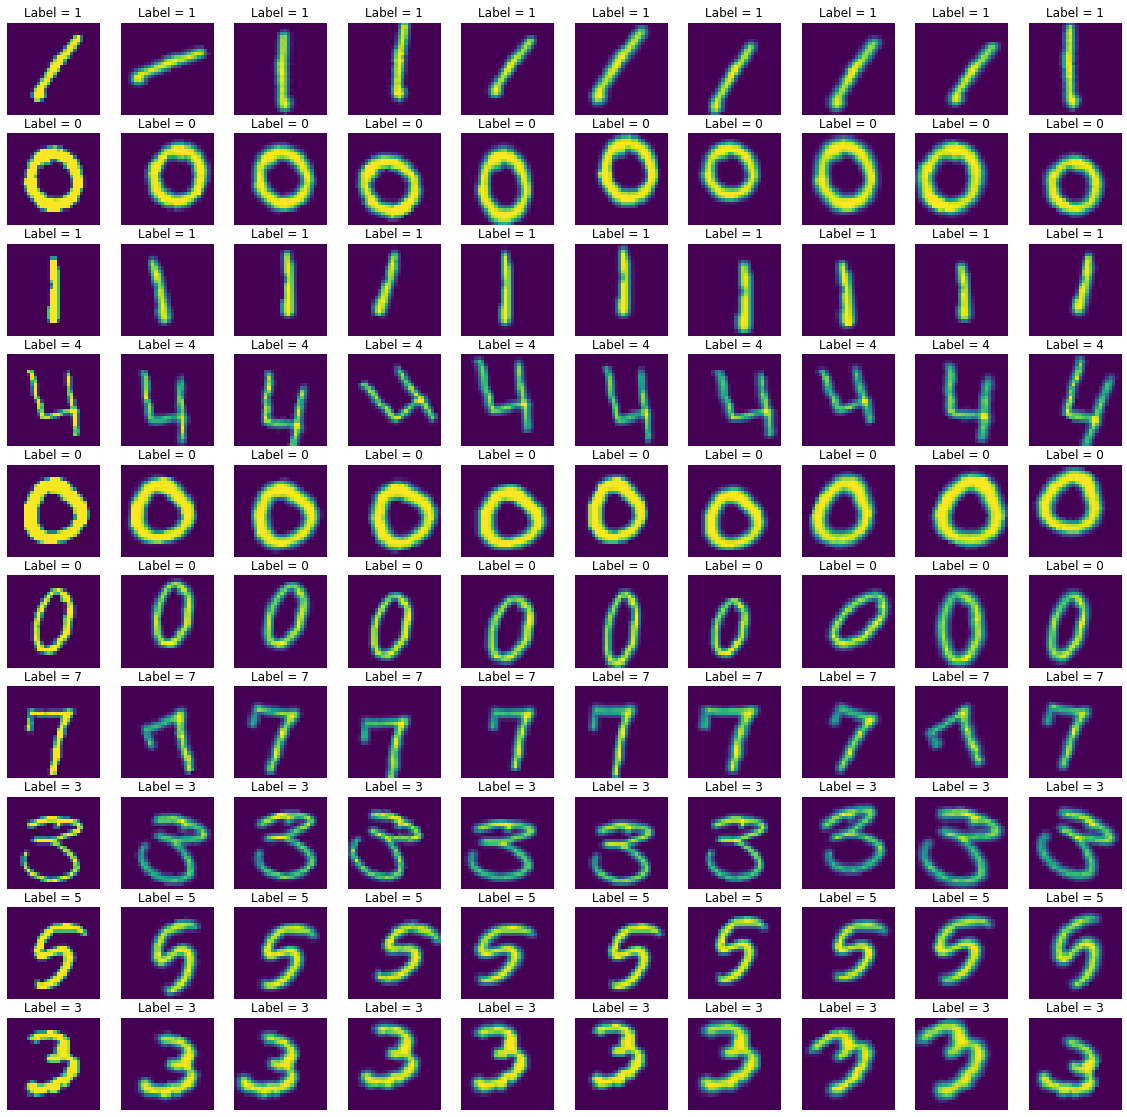

In [14]:
X10 = df_train[0:10]
y10 = y_train[0:10]
X100, y100 = data_augmentation(X10, y10)

fig=plt.figure(figsize=(20,20))
pos = 1
for i in range(0, 10):
    for j in range(i+0, i+100, 10):
        fig.add_subplot(10, 10, pos)
        plt.imshow(tf.squeeze(X100[j]))
        plt.title('Label = ' + str(y100[j]))
        plt.axis('off')
        pos = pos + 1
plt.show()

# 2. Build Neural Networks

## 2.0 Build the Neural Network Structure

In [15]:
def build_model(hidden_layers, hidden_nodes, dropout):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

  for i in range(1,hidden_layers+1):
    model.add(tf.keras.layers.Dense(hidden_nodes, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", # This loss function is needed for the fact the y-values are 0-9
              optimizer="sgd",
              metrics=["accuracy"])

  return model

model = build_model(hidden_layers = 2, hidden_nodes = 300, dropout = 0.2)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                3010      
                                                                 
Total params: 328,810
Trainable params: 328,810
Non-tr

In [16]:
# This code edits whether the models will be generated
# Setting a model to "true" means that it will not be generated.  If "false" then the model will be generated and written down

Model1_exist = False
Model2_exist = False
Model3_exist = False
Model4_exist = False
Model5_exist = False
Model6_exist = False


In [17]:
N_EPOCHS = 100

# I use Cross Validation with N_SPLITS. 
N_SPLITS = 5

# N_ITERATION allows me to run less iterations to save time.
# If N_ITERATION < N_SPLITS then the number of trainings/evaluations will stop earlier.
N_ITERATION = 1

## 2.1.1 Model1 (2layer, 300node) Training with Cross-Validation

In [18]:
# Creating hist_df to store history objects for each training / split

if Model1_exist == False:
  hist_df = pd.DataFrame(columns=['iteration', 'history'])
  iteration = 1
  index = 0

  hidden_layers = 2
  hidden_nodes = 300
  dropout = 0.2

  # This boolean variable is used to save one model only. 
  saved_model = False

  # Reshaping X_train from Keras input format (42000, 28, 28, 1) to (n_samples, n_features) format (42000, 784) as expected by StratifiedKFold.split() function
  X_train = df_train.reshape(42000, 784)

  # Training and evaluating the model 5 times, each time with a different training/validation set
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=422)
  for train_index, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
      
      # Getting the training set and validation set before data augmentation
      X_train_, X_val_ = X_train[train_index], X_train[val_index]
      X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
      X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
      y_train_, y_val_ = y_train[train_index], y_train[val_index]
      
      # Generating augmented samples
      X_train_, y_train_ = data_augmentation(X_train_, y_train_) #X_train_ is now (336000,28,28,1) and y_train_ is now (336000)
      
      # Building the model
      model = build_model(hidden_layers, hidden_nodes, dropout)
      
      # EDIT THE NEXT ROW FOR EACH MODEL
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk7Model1.h5", save_best_only=True)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
      
      # Training and evaluating each model for this split
      history = model.fit(x=X_train_, y=y_train_, 
                          validation_data=(X_val_, y_val_), 
                          epochs=N_EPOCHS, batch_size=64, 
                          callbacks=[checkpoint_cb, early_stopping_cb])
      
      # Saving the trained model as a saved model file -- only one model is saved
      if(saved_model == False):
          model.save('Wk7Model1')
          saved_model = True
      
      # Storing the history objects into a dataframe 
      hist_df.loc[index, 'iteration'] = iteration
      hist_df.loc[index, 'history'] = history
      
      if(iteration == N_ITERATION):
          break
          
      index = index + 1
      iteration = iteration + 1

Epoch 1/100
5250/5250 [==============================] - 35s 7ms/step - loss: 0.4377 - accuracy: 0.8740 - val_loss: 0.2179 - val_accuracy: 0.9395
Epoch 2/100
5250/5250 [==============================] - 33s 6ms/step - loss: 0.1977 - accuracy: 0.9420 - val_loss: 0.1574 - val_accuracy: 0.9538
Epoch 3/100
5250/5250 [==============================] - 34s 7ms/step - loss: 0.1421 - accuracy: 0.9581 - val_loss: 0.1277 - val_accuracy: 0.9626
Epoch 4/100
5250/5250 [==============================] - 33s 6ms/step - loss: 0.1094 - accuracy: 0.9673 - val_loss: 0.1116 - val_accuracy: 0.9674
Epoch 5/100
5250/5250 [==============================] - 34s 6ms/step - loss: 0.0891 - accuracy: 0.9734 - val_loss: 0.1003 - val_accuracy: 0.9713
Epoch 6/100
5250/5250 [==============================] - 34s 7ms/step - loss: 0.0745 - accuracy: 0.9779 - val_loss: 0.0934 - val_accuracy: 0.9731
Epoch 7/100
5250/5250 [==============================] - 34s 6ms/step - loss: 0.0631 - accuracy: 0.9812 - val_loss: 0.0893 -

### 2.1.2 Model1 Performance Evaluation

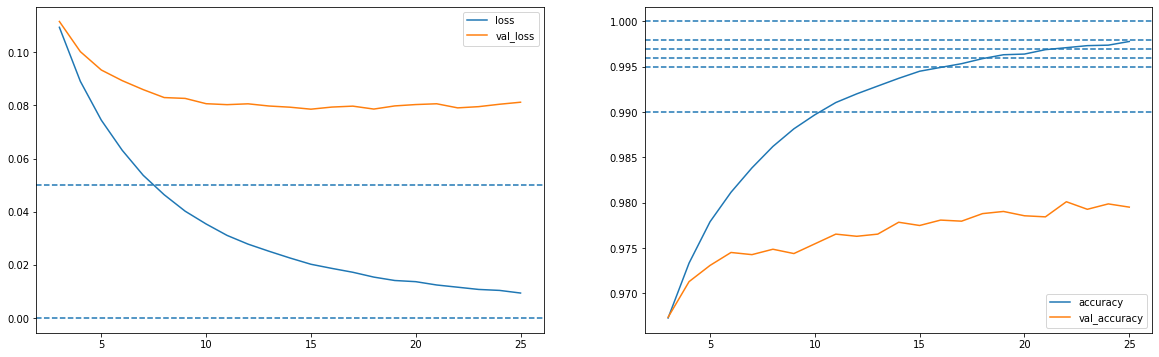

In [19]:
if Model1_exist == False:
  hist = []
  for i in range(N_ITERATION):
      hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
      if i==0:
          hist_full = hist[0]
      else:
          hist_full = pd.concat([hist_full, hist[i]])

  # Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low 
  hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration     

  # Displaying CV metrics
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

## 2.2.1 Model2 (3layer, 300node) Training with Cross-Validation

In [20]:
# Creating hist_df to store history objects for each training / split

if Model2_exist == False:
  hist_df = pd.DataFrame(columns=['iteration', 'history'])
  iteration = 1
  index = 0

  hidden_layers = 3
  hidden_nodes = 300
  dropout = 0.2

  # This boolean variable is used to save one model only. 
  saved_model = False

  # Reshaping X_train from Keras input format (42000, 28, 28, 1) to (n_samples, n_features) format (42000, 784) as expected by StratifiedKFold.split() function
  X_train = df_train.reshape(42000, 784)

  # Training and evaluating the model 5 times, each time with a different training/validation set
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=422)
  for train_index, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
      
      # Getting the training set and validation set before data augmentation
      X_train_, X_val_ = X_train[train_index], X_train[val_index]
      X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
      X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
      y_train_, y_val_ = y_train[train_index], y_train[val_index]
      
      # Generating augmented samples
      X_train_, y_train_ = data_augmentation(X_train_, y_train_) #X_train_ is now (336000,28,28,1) and y_train_ is now (336000)
      
      # Building the model
      model = build_model(hidden_layers, hidden_nodes, dropout)
      
      # EDIT THE NEXT ROW FOR EACH MODEL
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk7Model2.h5", save_best_only=True)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
      
      # Training and evaluating each model for this split
      history = model.fit(x=X_train_, y=y_train_, 
                          validation_data=(X_val_, y_val_), 
                          epochs=N_EPOCHS, batch_size=64, 
                          callbacks=[checkpoint_cb, early_stopping_cb])
      
      # Saving the trained model as a saved model file -- only one model is saved
      if(saved_model == False):
          model.save('Wk7Model2')
          saved_model = True
      
      # Storing the history objects into a dataframe 
      hist_df.loc[index, 'iteration'] = iteration
      hist_df.loc[index, 'history'] = history
      
      if(iteration == N_ITERATION):
          break
          
      index = index + 1
      iteration = iteration + 1

Epoch 1/100
5250/5250 [==============================] - 44s 8ms/step - loss: 0.4492 - accuracy: 0.8656 - val_loss: 0.1952 - val_accuracy: 0.9419
Epoch 2/100
5250/5250 [==============================] - 41s 8ms/step - loss: 0.1782 - accuracy: 0.9461 - val_loss: 0.1327 - val_accuracy: 0.9595
Epoch 3/100
5250/5250 [==============================] - 42s 8ms/step - loss: 0.1211 - accuracy: 0.9632 - val_loss: 0.1082 - val_accuracy: 0.9685
Epoch 4/100
5250/5250 [==============================] - 42s 8ms/step - loss: 0.0894 - accuracy: 0.9723 - val_loss: 0.0956 - val_accuracy: 0.9712
Epoch 5/100
5250/5250 [==============================] - 41s 8ms/step - loss: 0.0690 - accuracy: 0.9785 - val_loss: 0.0889 - val_accuracy: 0.9743
Epoch 6/100
5250/5250 [==============================] - 41s 8ms/step - loss: 0.0541 - accuracy: 0.9831 - val_loss: 0.0846 - val_accuracy: 0.9752
Epoch 7/100
5250/5250 [==============================] - 42s 8ms/step - loss: 0.0437 - accuracy: 0.9861 - val_loss: 0.0835 -

### 2.2.2 Model2 Performance Evaluation

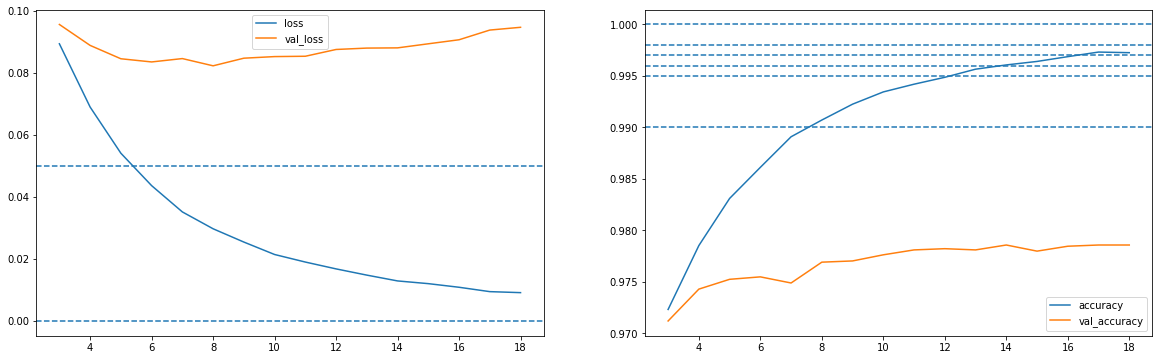

In [21]:
if Model2_exist == False:
  hist = []
  for i in range(N_ITERATION):
      hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
      if i==0:
          hist_full = hist[0]
      else:
          hist_full = pd.concat([hist_full, hist[i]])

  # Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low 
  hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration     

  # Displaying CV metrics
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

## 2.3.1 Model3 (2layer, 100node) Training with Cross-Validation

In [22]:
# Creating hist_df to store history objects for each training / split

if Model3_exist == False:
  hist_df = pd.DataFrame(columns=['iteration', 'history'])
  iteration = 1
  index = 0

  hidden_layers = 2
  hidden_nodes = 100
  dropout = 0.2

  # This boolean variable is used to save one model only. 
  saved_model = False

  # Reshaping X_train from Keras input format (42000, 28, 28, 1) to (n_samples, n_features) format (42000, 784) as expected by StratifiedKFold.split() function
  X_train = df_train.reshape(42000, 784)

  # Training and evaluating the model 5 times, each time with a different training/validation set
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=422)
  for train_index, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
      
      # Getting the training set and validation set before data augmentation
      X_train_, X_val_ = X_train[train_index], X_train[val_index]
      X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
      X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
      y_train_, y_val_ = y_train[train_index], y_train[val_index]
      
      # Generating augmented samples
      X_train_, y_train_ = data_augmentation(X_train_, y_train_) #X_train_ is now (336000,28,28,1) and y_train_ is now (336000)
      
      # Building the model
      model = build_model(hidden_layers, hidden_nodes, dropout)
      
      # EDIT THE NEXT ROW FOR EACH MODEL
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk7Model3.h5", save_best_only=True)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
      
      # Training and evaluating each model for this split
      history = model.fit(x=X_train_, y=y_train_, 
                          validation_data=(X_val_, y_val_), 
                          epochs=N_EPOCHS, batch_size=64, 
                          callbacks=[checkpoint_cb, early_stopping_cb])
      
      # Saving the trained model as a saved model file -- only one model is saved
      if(saved_model == False):
          model.save('Wk7Model3')
          saved_model = True
      
      # Storing the history objects into a dataframe 
      hist_df.loc[index, 'iteration'] = iteration
      hist_df.loc[index, 'history'] = history
      
      if(iteration == N_ITERATION):
          break
          
      index = index + 1
      iteration = iteration + 1

Epoch 1/100
5250/5250 [==============================] - 19s 3ms/step - loss: 0.5281 - accuracy: 0.8411 - val_loss: 0.2460 - val_accuracy: 0.9273
Epoch 2/100
5250/5250 [==============================] - 18s 3ms/step - loss: 0.2542 - accuracy: 0.9243 - val_loss: 0.1816 - val_accuracy: 0.9457
Epoch 3/100
5250/5250 [==============================] - 18s 3ms/step - loss: 0.1951 - accuracy: 0.9421 - val_loss: 0.1501 - val_accuracy: 0.9544
Epoch 4/100
5250/5250 [==============================] - 17s 3ms/step - loss: 0.1605 - accuracy: 0.9519 - val_loss: 0.1313 - val_accuracy: 0.9599
Epoch 5/100
5250/5250 [==============================] - 18s 3ms/step - loss: 0.1373 - accuracy: 0.9580 - val_loss: 0.1206 - val_accuracy: 0.9643
Epoch 6/100
5250/5250 [==============================] - 17s 3ms/step - loss: 0.1204 - accuracy: 0.9632 - val_loss: 0.1136 - val_accuracy: 0.9660
Epoch 7/100
5250/5250 [==============================] - 17s 3ms/step - loss: 0.1069 - accuracy: 0.9671 - val_loss: 0.1072 -

### 2.3.2 Model3 Performance Evaluation

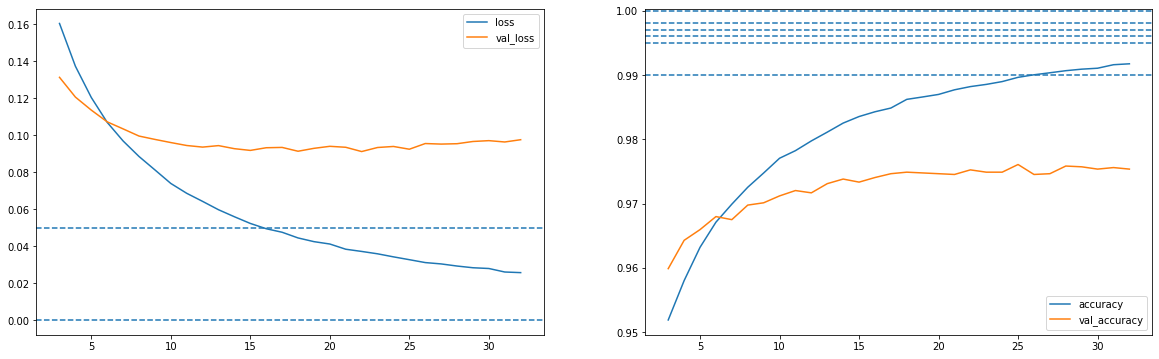

In [23]:
if Model3_exist == False:
  hist = []
  for i in range(N_ITERATION):
      hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
      if i==0:
          hist_full = hist[0]
      else:
          hist_full = pd.concat([hist_full, hist[i]])

  # Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low 
  hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration     

  # Displaying CV metrics
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

## 2.4.1 Model4 (3layer, 100node) Training with Cross-Validation

In [24]:
# Creating hist_df to store history objects for each training / split

if Model4_exist == False:
  hist_df = pd.DataFrame(columns=['iteration', 'history'])
  iteration = 1
  index = 0

  hidden_layers = 3
  hidden_nodes = 100
  dropout = 0.2

  # This boolean variable is used to save one model only. 
  saved_model = False

  # Reshaping X_train from Keras input format (42000, 28, 28, 1) to (n_samples, n_features) format (42000, 784) as expected by StratifiedKFold.split() function
  X_train = df_train.reshape(42000, 784)

  # Training and evaluating the model 5 times, each time with a different training/validation set
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=422)
  for train_index, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
      
      # Getting the training set and validation set before data augmentation
      X_train_, X_val_ = X_train[train_index], X_train[val_index]
      X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
      X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
      y_train_, y_val_ = y_train[train_index], y_train[val_index]
      
      # Generating augmented samples
      X_train_, y_train_ = data_augmentation(X_train_, y_train_) #X_train_ is now (336000,28,28,1) and y_train_ is now (336000)
      
      # Building the model
      model = build_model(hidden_layers, hidden_nodes, dropout)
      
      # EDIT THE NEXT ROW FOR EACH MODEL
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk7Model4.h5", save_best_only=True)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
      
      # Training and evaluating each model for this split
      history = model.fit(x=X_train_, y=y_train_, 
                          validation_data=(X_val_, y_val_), 
                          epochs=N_EPOCHS, batch_size=64, 
                          callbacks=[checkpoint_cb, early_stopping_cb])
      
      # Saving the trained model as a saved model file -- only one model is saved
      if(saved_model == False):
          model.save('Wk7Model4')
          saved_model = True
      
      # Storing the history objects into a dataframe 
      hist_df.loc[index, 'iteration'] = iteration
      hist_df.loc[index, 'history'] = history
      
      if(iteration == N_ITERATION):
          break
          
      index = index + 1
      iteration = iteration + 1

Epoch 1/100
5250/5250 [==============================] - 21s 4ms/step - loss: 0.5858 - accuracy: 0.8171 - val_loss: 0.2255 - val_accuracy: 0.9320
Epoch 2/100
5250/5250 [==============================] - 20s 4ms/step - loss: 0.2496 - accuracy: 0.9258 - val_loss: 0.1570 - val_accuracy: 0.9539
Epoch 3/100
5250/5250 [==============================] - 19s 4ms/step - loss: 0.1836 - accuracy: 0.9451 - val_loss: 0.1326 - val_accuracy: 0.9594
Epoch 4/100
5250/5250 [==============================] - 19s 4ms/step - loss: 0.1471 - accuracy: 0.9558 - val_loss: 0.1164 - val_accuracy: 0.9648
Epoch 5/100
5250/5250 [==============================] - 19s 4ms/step - loss: 0.1238 - accuracy: 0.9626 - val_loss: 0.1089 - val_accuracy: 0.9661
Epoch 6/100
5250/5250 [==============================] - 19s 4ms/step - loss: 0.1072 - accuracy: 0.9673 - val_loss: 0.1036 - val_accuracy: 0.9686
Epoch 7/100
5250/5250 [==============================] - 19s 4ms/step - loss: 0.0933 - accuracy: 0.9711 - val_loss: 0.1019 -

### 2.4.2 Model4 Performance Evaluation

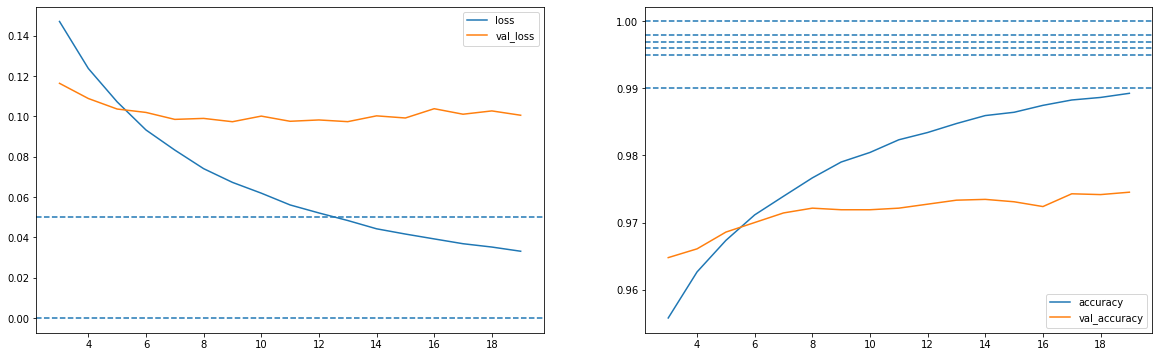

In [25]:
if Model4_exist == False:
  hist = []
  for i in range(N_ITERATION):
      hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
      if i==0:
          hist_full = hist[0]
      else:
          hist_full = pd.concat([hist_full, hist[i]])

  # Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low 
  hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration     

  # Displaying CV metrics
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

## 2.5.1 Model5 (1layer, 100node) Training with Cross-Validation

In [26]:
# Creating hist_df to store history objects for each training / split

if Model5_exist == False:
  hist_df = pd.DataFrame(columns=['iteration', 'history'])
  iteration = 1
  index = 0

  hidden_layers = 1
  hidden_nodes = 100
  dropout = 0.2

  # This boolean variable is used to save one model only. 
  saved_model = False

  # Reshaping X_train from Keras input format (42000, 28, 28, 1) to (n_samples, n_features) format (42000, 784) as expected by StratifiedKFold.split() function
  X_train = df_train.reshape(42000, 784)

  # Training and evaluating the model 5 times, each time with a different training/validation set
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=422)
  for train_index, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
      
      # Getting the training set and validation set before data augmentation
      X_train_, X_val_ = X_train[train_index], X_train[val_index]
      X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
      X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
      y_train_, y_val_ = y_train[train_index], y_train[val_index]
      
      # Generating augmented samples
      X_train_, y_train_ = data_augmentation(X_train_, y_train_) #X_train_ is now (336000,28,28,1) and y_train_ is now (336000)
      
      # Building the model
      model = build_model(hidden_layers, hidden_nodes, dropout)
      
      # EDIT THE NEXT ROW FOR EACH MODEL
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk7Model5.h5", save_best_only=True)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
      
      # Training and evaluating each model for this split
      history = model.fit(x=X_train_, y=y_train_, 
                          validation_data=(X_val_, y_val_), 
                          epochs=N_EPOCHS, batch_size=64, 
                          callbacks=[checkpoint_cb, early_stopping_cb])
      
      # Saving the trained model as a saved model file -- only one model is saved
      if(saved_model == False):
          model.save('Wk7Model5')
          saved_model = True
      
      # Storing the history objects into a dataframe 
      hist_df.loc[index, 'iteration'] = iteration
      hist_df.loc[index, 'history'] = history
      
      if(iteration == N_ITERATION):
          break
          
      index = index + 1
      iteration = iteration + 1

Epoch 1/100
5250/5250 [==============================] - 17s 3ms/step - loss: 0.4986 - accuracy: 0.8590 - val_loss: 0.2888 - val_accuracy: 0.9176
Epoch 2/100
5250/5250 [==============================] - 16s 3ms/step - loss: 0.2713 - accuracy: 0.9225 - val_loss: 0.2234 - val_accuracy: 0.9361
Epoch 3/100
5250/5250 [==============================] - 16s 3ms/step - loss: 0.2144 - accuracy: 0.9391 - val_loss: 0.1880 - val_accuracy: 0.9464
Epoch 4/100
5250/5250 [==============================] - 16s 3ms/step - loss: 0.1817 - accuracy: 0.9482 - val_loss: 0.1659 - val_accuracy: 0.9526
Epoch 5/100
5250/5250 [==============================] - 16s 3ms/step - loss: 0.1589 - accuracy: 0.9550 - val_loss: 0.1500 - val_accuracy: 0.9576
Epoch 6/100
5250/5250 [==============================] - 16s 3ms/step - loss: 0.1426 - accuracy: 0.9593 - val_loss: 0.1394 - val_accuracy: 0.9600
Epoch 7/100
5250/5250 [==============================] - 16s 3ms/step - loss: 0.1298 - accuracy: 0.9631 - val_loss: 0.1303 -

### 2.5.2 Model5 Performance Evaluation

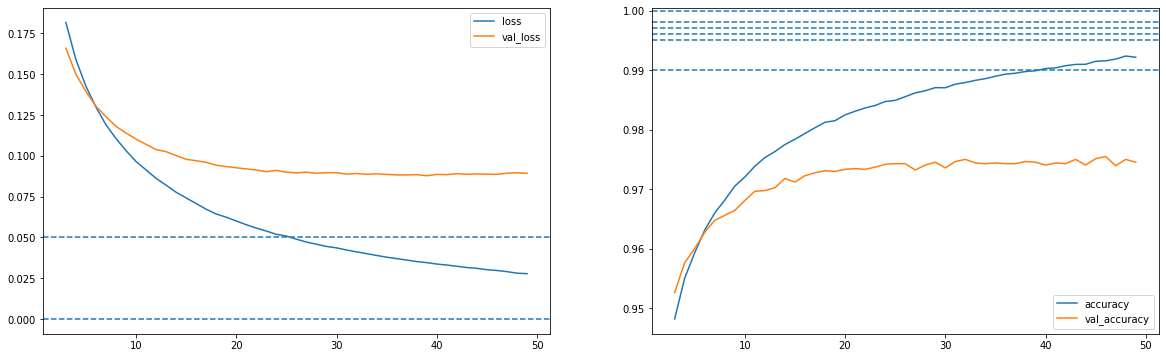

In [27]:
if Model5_exist == False:
  hist = []
  for i in range(N_ITERATION):
      hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
      if i==0:
          hist_full = hist[0]
      else:
          hist_full = pd.concat([hist_full, hist[i]])

  # Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low 
  hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration     

  # Displaying CV metrics
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

## 2.6.1 Model6 (5layer, 100node) Training with Cross-Validation

In [28]:
# Creating hist_df to store history objects for each training / split

if Model6_exist == False:
  hist_df = pd.DataFrame(columns=['iteration', 'history'])
  iteration = 1
  index = 0

  hidden_layers = 5
  hidden_nodes = 100
  dropout = 0.2

  # This boolean variable is used to save one model only. 
  saved_model = False

  # Reshaping X_train from Keras input format (42000, 28, 28, 1) to (n_samples, n_features) format (42000, 784) as expected by StratifiedKFold.split() function
  X_train = df_train.reshape(42000, 784)

  # Training and evaluating the model 5 times, each time with a different training/validation set
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=422)
  for train_index, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
      
      # Getting the training set and validation set before data augmentation
      X_train_, X_val_ = X_train[train_index], X_train[val_index]
      X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
      X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
      y_train_, y_val_ = y_train[train_index], y_train[val_index]
      
      # Generating augmented samples
      X_train_, y_train_ = data_augmentation(X_train_, y_train_) #X_train_ is now (336000,28,28,1) and y_train_ is now (336000)
      
      # Building the model
      model = build_model(hidden_layers, hidden_nodes, dropout)
      
      # EDIT THE NEXT ROW FOR EACH MODEL
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk7Model6.h5", save_best_only=True)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
      
      # Training and evaluating each model for this split
      history = model.fit(x=X_train_, y=y_train_, 
                          validation_data=(X_val_, y_val_), 
                          epochs=N_EPOCHS, batch_size=64, 
                          callbacks=[checkpoint_cb, early_stopping_cb])
      
      # Saving the trained model as a saved model file -- only one model is saved
      if(saved_model == False):
          model.save('Wk7Model6')
          saved_model = True
      
      # Storing the history objects into a dataframe 
      hist_df.loc[index, 'iteration'] = iteration
      hist_df.loc[index, 'history'] = history
      
      if(iteration == N_ITERATION):
          break
          
      index = index + 1
      iteration = iteration + 1

Epoch 1/100
5250/5250 [==============================] - 23s 4ms/step - loss: 0.8140 - accuracy: 0.7335 - val_loss: 0.2318 - val_accuracy: 0.9317
Epoch 2/100
5250/5250 [==============================] - 22s 4ms/step - loss: 0.2720 - accuracy: 0.9231 - val_loss: 0.1636 - val_accuracy: 0.9544
Epoch 3/100
5250/5250 [==============================] - 22s 4ms/step - loss: 0.1890 - accuracy: 0.9467 - val_loss: 0.1411 - val_accuracy: 0.9619
Epoch 4/100
5250/5250 [==============================] - 26s 5ms/step - loss: 0.1436 - accuracy: 0.9593 - val_loss: 0.1311 - val_accuracy: 0.9650
Epoch 5/100
5250/5250 [==============================] - 22s 4ms/step - loss: 0.1172 - accuracy: 0.9667 - val_loss: 0.1237 - val_accuracy: 0.9677
Epoch 6/100
5250/5250 [==============================] - 22s 4ms/step - loss: 0.0989 - accuracy: 0.9718 - val_loss: 0.1271 - val_accuracy: 0.9675
Epoch 7/100
5250/5250 [==============================] - 22s 4ms/step - loss: 0.0853 - accuracy: 0.9756 - val_loss: 0.1297 -

### 2.6.2 Model6 Performance Evaluation

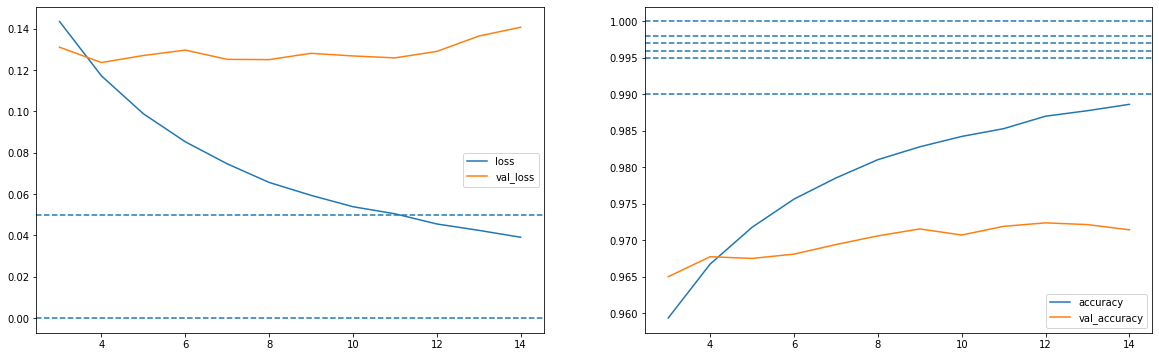

In [29]:
if Model6_exist == False:
  hist = []
  for i in range(N_ITERATION):
      hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
      if i==0:
          hist_full = hist[0]
      else:
          hist_full = pd.concat([hist_full, hist[i]])

  # Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low 
  hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration     

  # Displaying CV metrics
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

# 3. Error Evaluations

## 3.1 Confusion Matrices

### 3.1.1 Model1 (2x300) Confusion Matrix

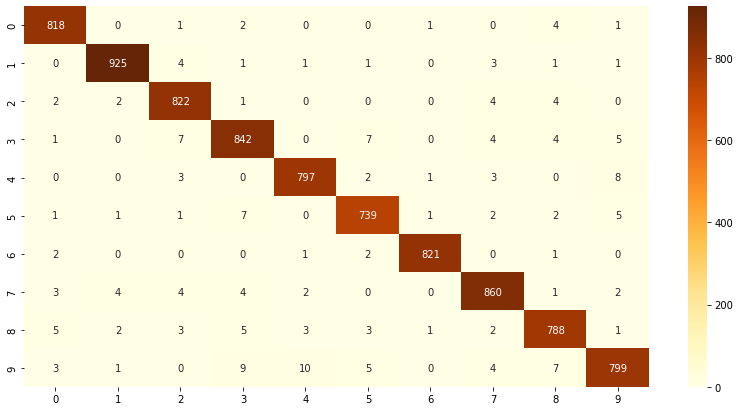

In [30]:
# Reloading the saved model -- this is the model trained in the 1st loop of the CV
model = keras.models.load_model('Wk7Model1')

X_train = df_train.reshape(42000, 784)

# Retrieving the validation set -- corresponding to the 1st loop of the CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)
for _, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

X_val = X_val.reshape(8400,28,28,1)    
    
# Making predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Displaying the confusion matrix
plt.figure(figsize = (14,7))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlOrBr')
plt.show()

### 3.1.2 Model2 (3x300) Confusion Matrix

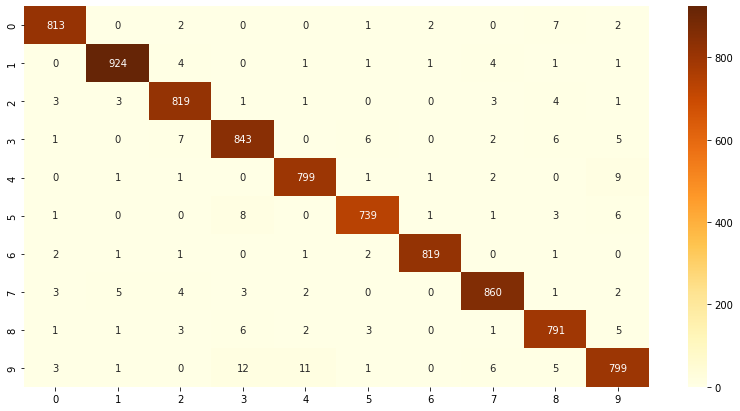

In [31]:
# Reloading the saved model -- this is the model trained in the 1st loop of the CV
model = keras.models.load_model('Wk7Model2')

X_train = df_train.reshape(42000, 784)

# Retrieving the validation set -- corresponding to the 1st loop of the CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)
for _, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

X_val = X_val.reshape(8400,28,28,1)    
    
# Making predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Displaying the confusion matrix
plt.figure(figsize = (14,7))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlOrBr')
plt.show()

### 3.1.3 Model3 (2x100) Confusion Matrix

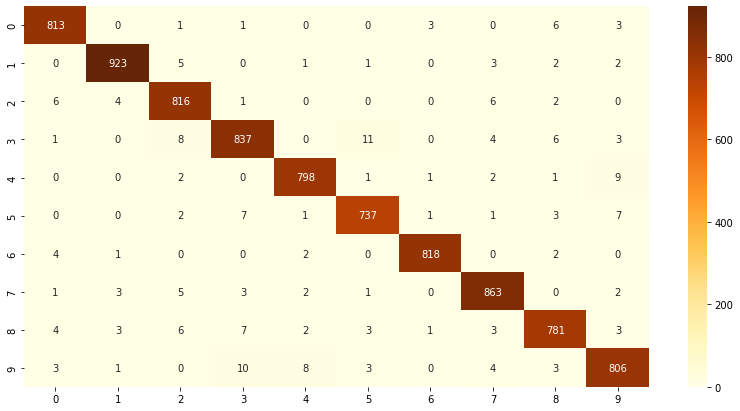

In [32]:
# Reloading the saved model -- this is the model trained in the 1st loop of the CV
model = keras.models.load_model('Wk7Model3')

X_train = df_train.reshape(42000, 784)

# Retrieving the validation set -- corresponding to the 1st loop of the CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)
for _, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

X_val = X_val.reshape(8400,28,28,1)    
    
# Making predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Displaying the confusion matrix
plt.figure(figsize = (14,7))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlOrBr')
plt.show()

### 3.1.4 Model4 (3x100) Confusion Matrix

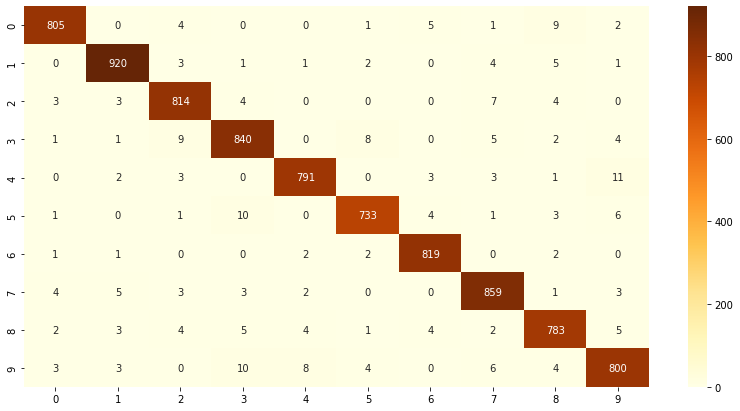

In [33]:
# Reloading the saved model -- this is the model trained in the 1st loop of the CV
model = keras.models.load_model('Wk7Model4')

X_train = df_train.reshape(42000, 784)

# Retrieving the validation set -- corresponding to the 1st loop of the CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)
for _, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

X_val = X_val.reshape(8400,28,28,1)    
    
# Making predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Displaying the confusion matrix
plt.figure(figsize = (14,7))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlOrBr')
plt.show()

### 3.1.5 Model5 (1x100) Confusion Matrix

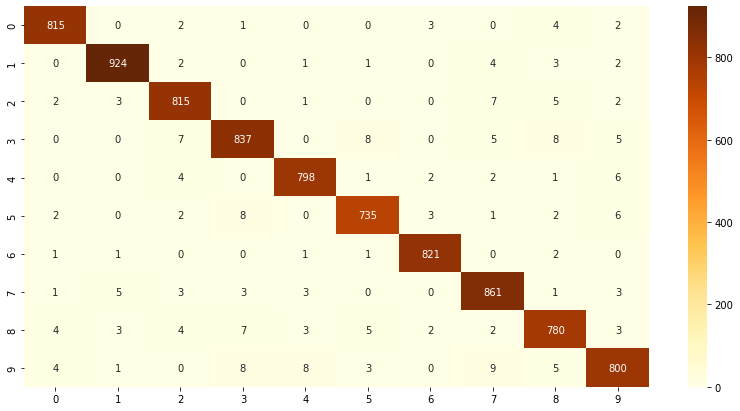

In [34]:
# Reloading the saved model -- this is the model trained in the 1st loop of the CV
model = keras.models.load_model('Wk7Model5')

X_train = df_train.reshape(42000, 784)

# Retrieving the validation set -- corresponding to the 1st loop of the CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)
for _, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

X_val = X_val.reshape(8400,28,28,1)    
    
# Making predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Displaying the confusion matrix
plt.figure(figsize = (14,7))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlOrBr')
plt.show()

### 3.1.6 Model5 (5x100) Confusion Matrix

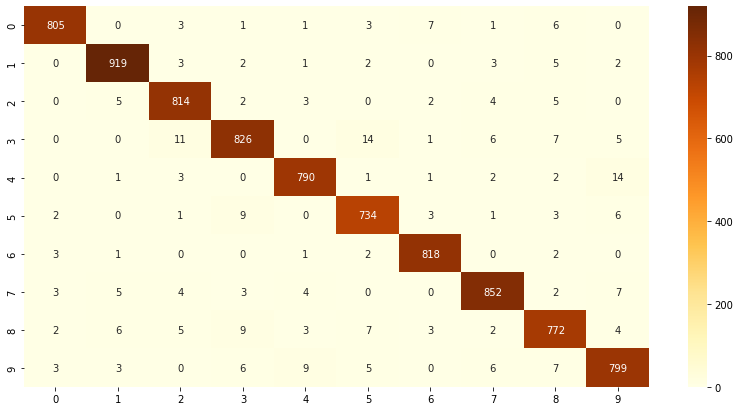

In [35]:
# Reloading the saved model -- this is the model trained in the 1st loop of the CV
model = keras.models.load_model('Wk7Model6')

X_train = df_train.reshape(42000, 784)

# Retrieving the validation set -- corresponding to the 1st loop of the CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)
for _, val_index in skf.split(X_train, y_train): # returns indices to build 10 splits of X_train, y_train, X_val, y_val
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

X_val = X_val.reshape(8400,28,28,1)    
    
# Making predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Displaying the confusion matrix
plt.figure(figsize = (14,7))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlOrBr')
plt.show()

# 4. Submit Models

In [36]:
X_test = df_test.copy()
X_test = X_test.reshape(28000,28,28,1)

model1 = keras.models.load_model('Wk7Model1')
model2 = keras.models.load_model('Wk7Model2')
model3 = keras.models.load_model('Wk7Model3')
model4 = keras.models.load_model('Wk7Model4')
model5 = keras.models.load_model('Wk7Model5')
model6 = keras.models.load_model('Wk7Model6')

predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)
predictions3 = model3.predict(X_test)
predictions4 = model4.predict(X_test)
predictions5 = model5.predict(X_test)
predictions6 = model6.predict(X_test)



In [38]:
output1 = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions1, axis=1)})
output2 = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions2, axis=1)})
output3 = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions3, axis=1)})
output4 = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions4, axis=1)})
output5 = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions5, axis=1)})
output6 = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions6, axis=1)})


output1.to_csv('Wk7Model1.csv', index=False)
output2.to_csv('Wk7Model2.csv', index=False)
output3.to_csv('Wk7Model3.csv', index=False)
output4.to_csv('Wk7Model4.csv', index=False)
output5.to_csv('Wk7Model5.csv', index=False)
output6.to_csv('Wk7Model6.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
